# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

## What is a time series problem?

Time series problems deal with data over time.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories : Classification or Forecasting. In both cases, it's a supervised learning problem.

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

## What we're going to cover

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)


## Get data

We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why these dates?

Because 01 October 2013 is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 18 May 2021 is when this notebook was created.

> 📖 **Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV".

In [1]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-06-12 14:24:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2025-06-12 14:24:25 (8.78 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas


In [2]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have?
len(df)

2787

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


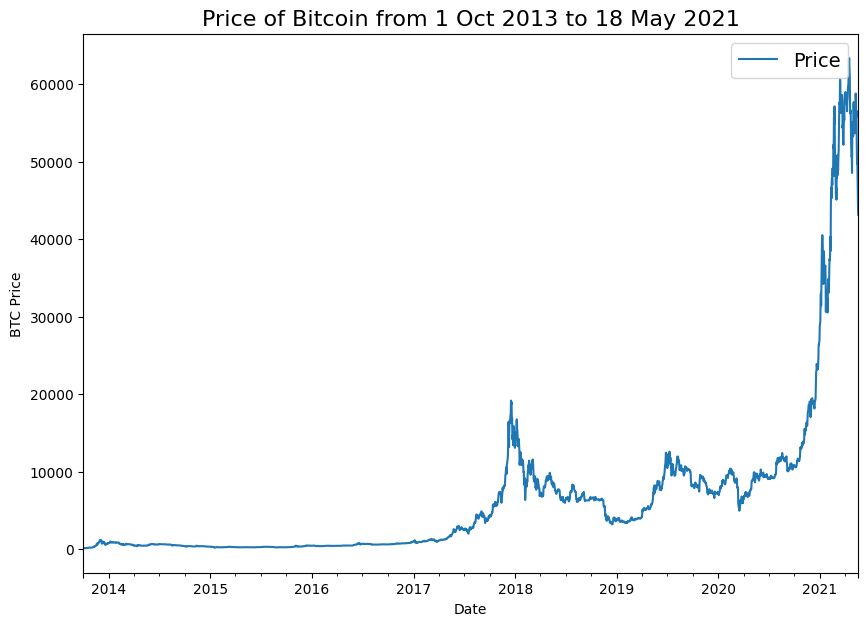

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [7]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]



([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

## Format Data Part 1: Creating train and test sets for time series data

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

### Create train & test sets for time series


![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)

In [8]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [9]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

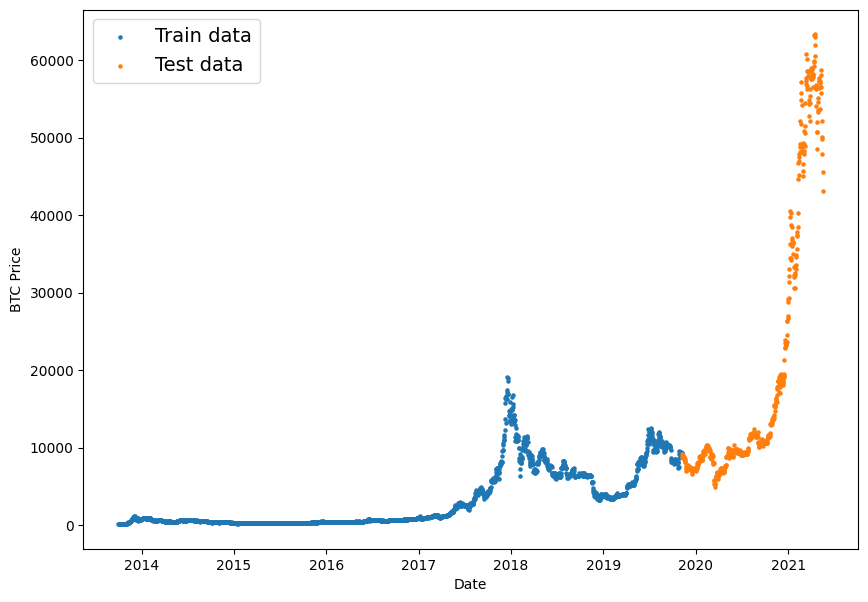

In [10]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

> 📖 **Resource:** The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data.



### Create a plotting function


In [11]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

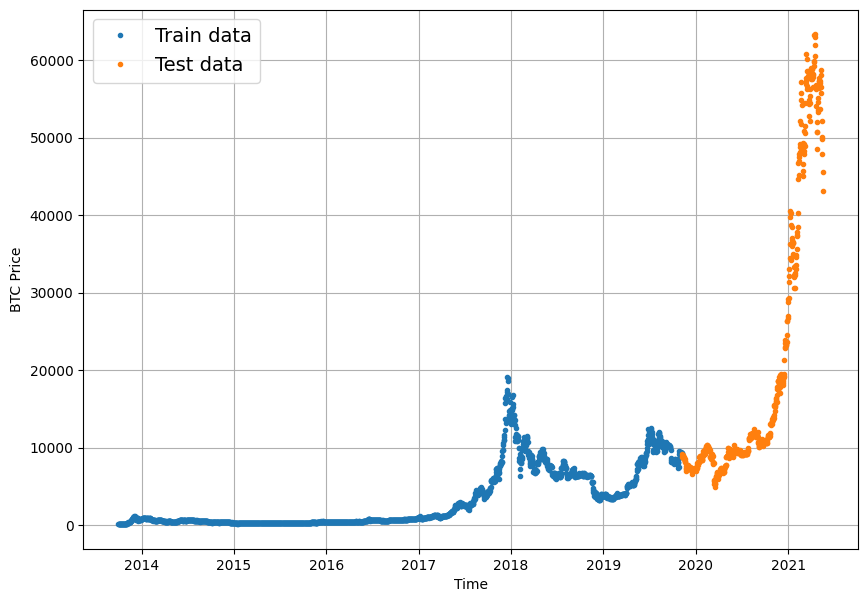

In [12]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**.
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |


## Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> 🔑 **Note:** An **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). A **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [13]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

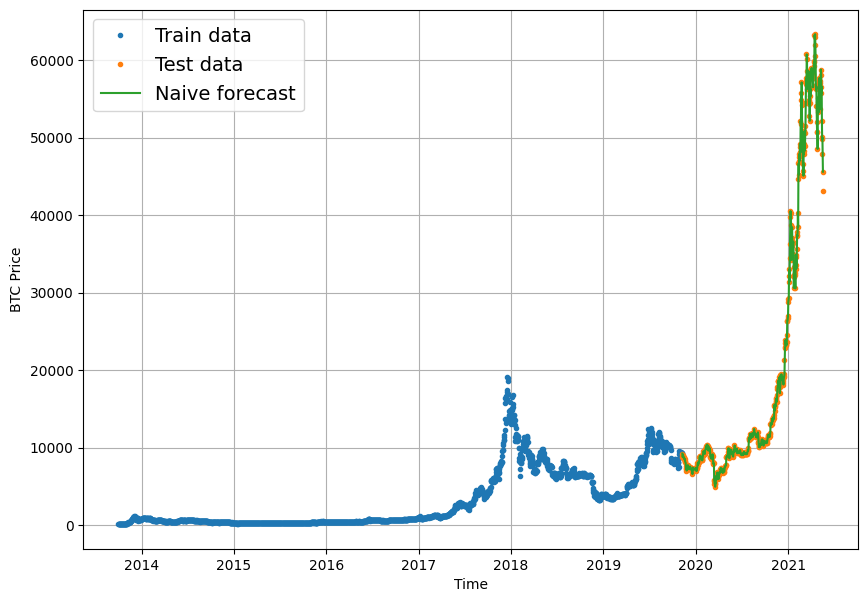

In [14]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

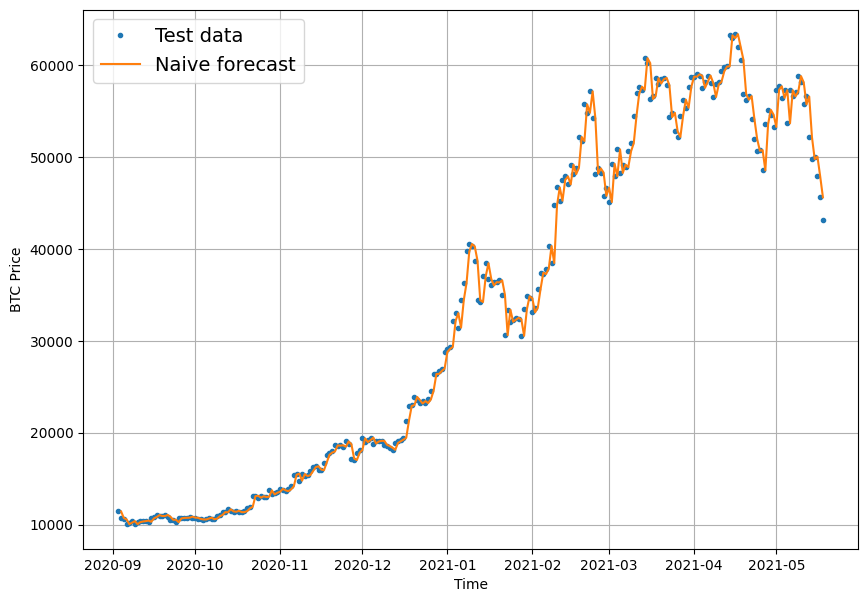

In [15]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

## Evaluating a time series model

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) |
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

In [16]:
# Let's get TensorFlow!
import tensorflow as tf

In [17]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

We're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set. The naïve model should achieve an MASE of 1 (or very close). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.


In [18]:
import sklearn.metrics as skmetrics

In [19]:
def evaluate_preds(y_true, y_pred):

  # Calculate various metrics
  mae = skmetrics.mean_absolute_error(y_true, y_pred)
  mse = skmetrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = skmetrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": round(mae,4),
          "mse": round(mse,4),
          "rmse": round(float(rmse.numpy()),4),
          "mape": round(mape,4),
          "mase": round(float(mase.numpy()),4)}

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.125,
 'rmse': 1071.2362,
 'mape': 0.0252,
 'mase': 0.9996}

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

Windowing is a method to turn a time series dataset into **supervised learning problem**.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] (Window=7) -> [7] (Horizon=1)
[1, 2, 3, 4, 5, 6, 7] (Window=7) -> [8] (Horizon=1)
[2, 3, 4, 5, 6, 7, 8] (Window=7) -> [9] (Horizon=1)
```

In [21]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [22]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [23]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multiple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [24]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [25]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [26]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [27]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance.

## Turning windows into training and test sets

Time to turn our windows into training and test splits.

Windowing often requires an offset at some point in the data, it usually works better to window the data first, then split it into training and test sets.

In [28]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [29]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [30]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## Make a modelling checkpoint

We want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

In [31]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+".keras"), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

`model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

(Values were picked out of experimentation.)

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 3961.7192 - mae: 3961.7192 - val_loss: 7547.0142 - val_mae: 7547.0142
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 684.6208 - mae: 684.6208 - val_loss: 1444.4093 - val_mae: 1444.4093
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 246.1324 - mae: 246.1324 - val_loss: 1218.2732 - val_mae: 1218.2732
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 208.6692 - mae: 208.6692 - val_loss: 1125.2435 - val_mae: 1125.2435
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 193.5727 - mae: 193.5727 - val_loss: 1122.0657 - val_mae: 1122.0657
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 189.0053 - mae: 189.0053 - val_loss: 1094.8704 - val_mae: 1094.8704
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 184.5971 - mae: 184.5971 - val_loss: 1063.2911 - val_mae: 1063.2911
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 179.8256 - mae: 179.8256 - val_loss: 1044.8965 - 

In [33]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 284.4656 - mae: 284.4656


[567.344482421875, 567.344482421875]

In [34]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 284.4656 - mae: 284.4656


[567.344482421875, 567.344482421875]

## Making forecasts with a model (on the test dataset)

Let's write a function which:
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [35]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [36]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8886.197, 8810.752, 9034.498, 8823.121, 8767.663, 8716.922,
        8717.074, 8556.82 , 8463.766, 8544.225], dtype=float32)>)

In [37]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=test_labels, # reduce to right shape
                                 y_pred=tf.cast(model_1_preds,dtype='float64').numpy())
model_1_results

{'mae': 567.3445,
 'mse': 1168344.2977,
 'rmse': 1080.8998,
 'mape': 0.0255,
 'mase': 30.134}

In [38]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.125,
 'rmse': 1071.2362,
 'mape': 0.0252,
 'mase': 0.9996}

It looks like our naïve model beats our first deep model on nearly every metric.

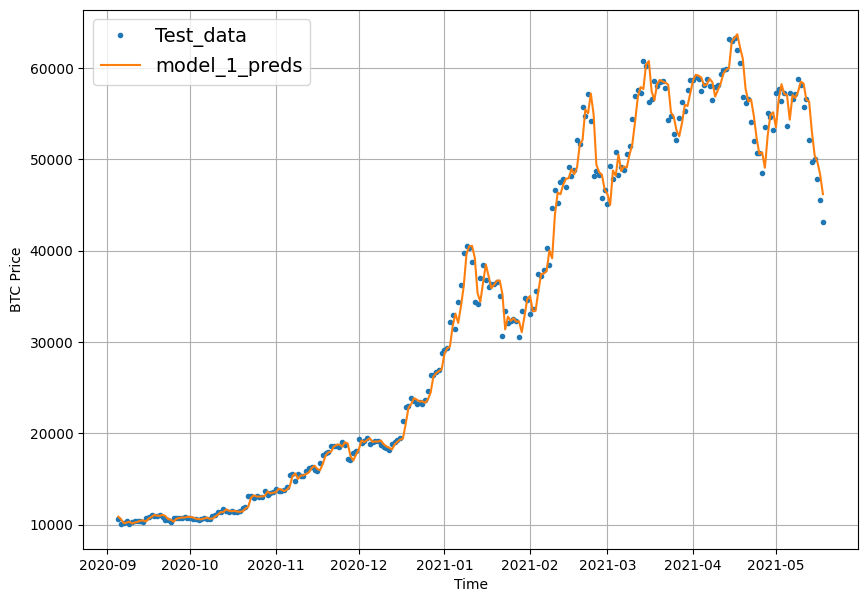

In [39]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

Window size and horizon are hyperparameters !!

In [40]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [41]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [42]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [43]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [44]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 320.3065


635.5550537109375

In [45]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 308.8824


613.8778686523438

In [46]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [47]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=test_labels, # remove 1 dimension of test labels
                                 y_pred=tf.cast(model_2_preds,dtype='float64').numpy())
model_2_results

{'mae': 613.8778,
 'mse': 1289892.4249,
 'rmse': 1135.7343,
 'mape': 0.0276,
 'mase': 30.1026}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

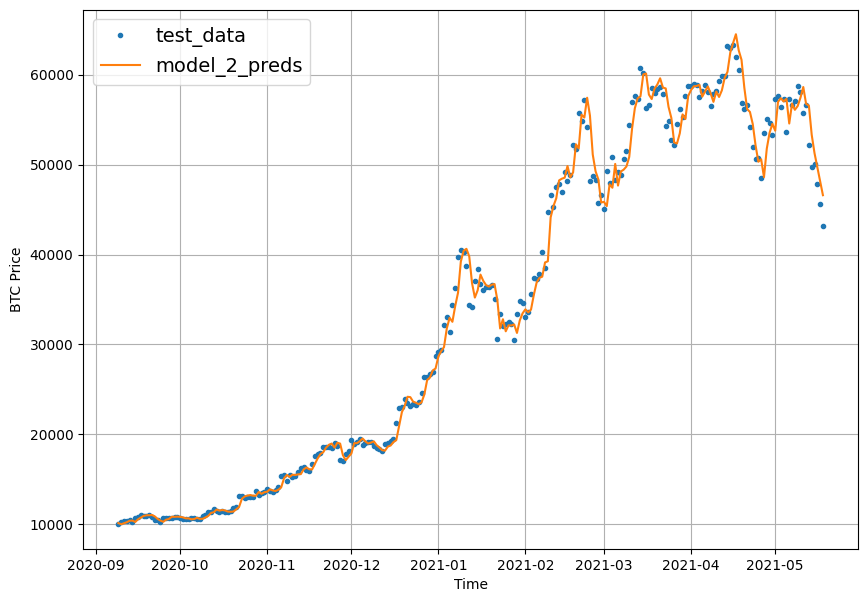

In [48]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [49]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [50]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [51]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [52]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 637.3574


1259.841796875

In [53]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 636.6876


1250.8824462890625

In [54]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9353.363 , 9168.102 , 9374.471 , 9396.208 , 9568.989 , 9515.402 ,
        9256.071 ],
       [9252.23  , 9016.338 , 9258.162 , 9184.496 , 9175.254 , 9357.037 ,
        9033.586 ],
       [9104.057 , 8915.977 , 9033.604 , 9110.841 , 9076.156 , 9266.229 ,
        8802.356 ],
       [9035.848 , 9072.167 , 9068.311 , 9106.734 , 9236.363 , 9158.031 ,
        8963.717 ],
       [8949.053 , 8923.264 , 8879.328 , 8923.533 , 9229.882 , 9034.174 ,
        8812.9795]], dtype=float32)>

In [55]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=tf.cast(model_3_preds,dtype='float64').numpy())
model_3_results

{'mae': 1250.8824,
 'mse': 5347685.8851,
 'rmse': 2312.5063,
 'mape': 0.0567,
 'mase': 2.2259}

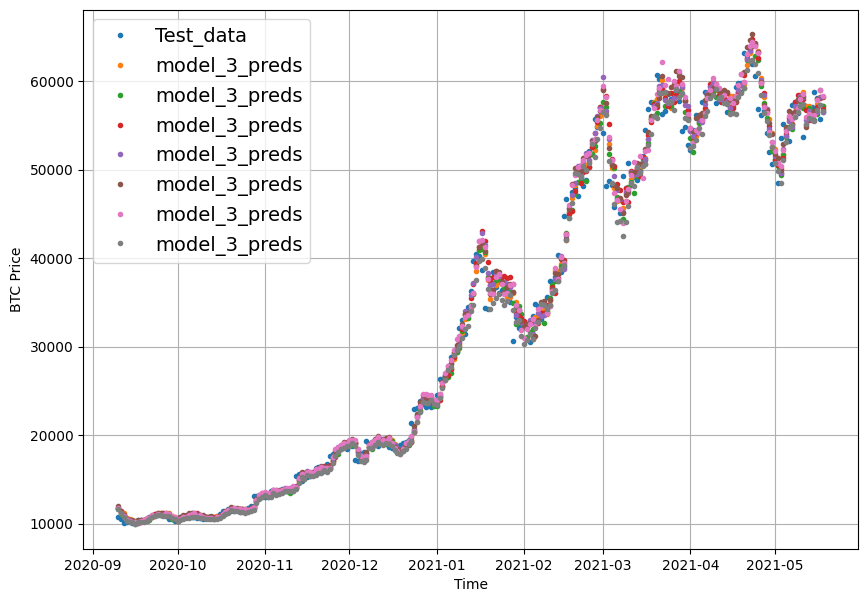

In [56]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

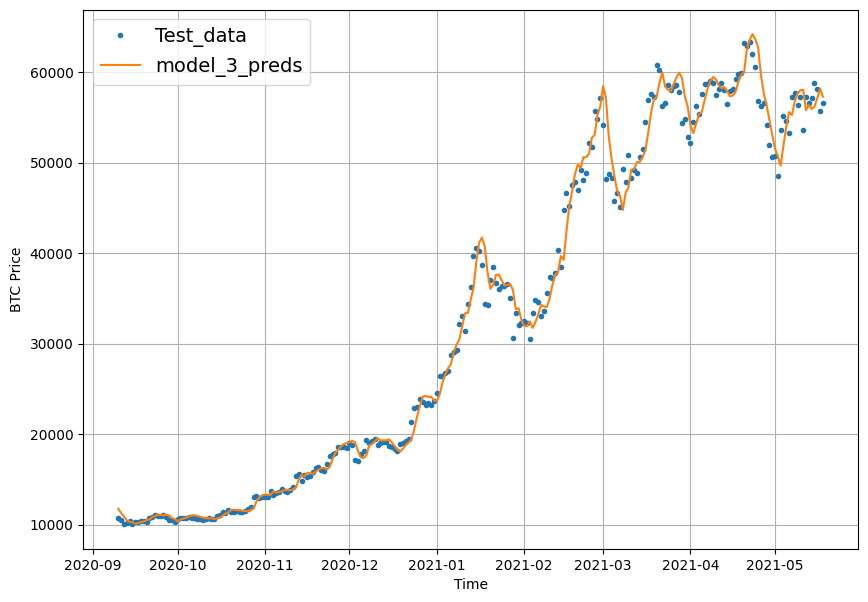

In [57]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

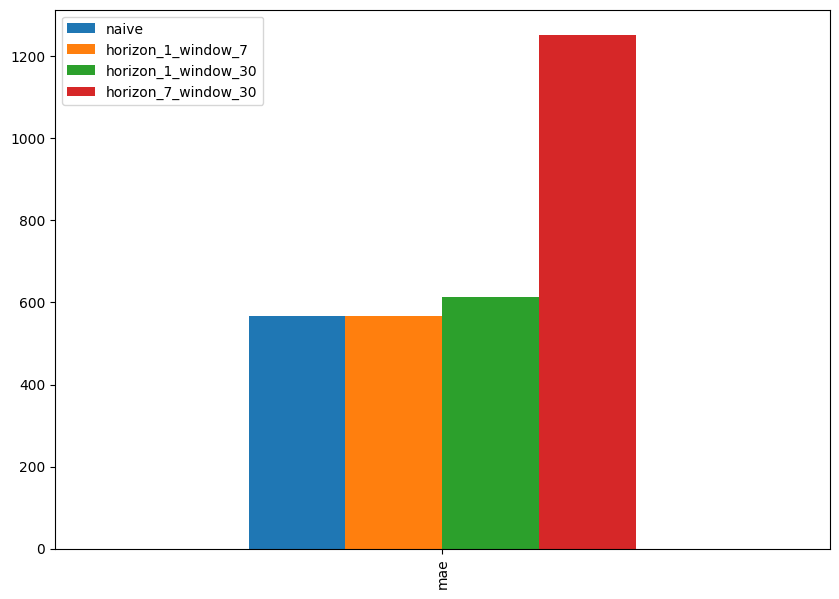

In [58]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Our naïve model is performing best but model_1 is the cloest.

Let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D


We'll use a Conv1D model for a seq2seq problem. In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (a many to one problem).

In [59]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [60]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [61]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension.

In [62]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [63]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [64]:
tf.random.set_seed(42)

# Def la fonction en dehors du Lambda pour eviter les erreurs
def expand_dim(x): #
    return tf.expand_dims(x, axis=1)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(expand_dim,name='expand_dim'), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [65]:
model_4.summary()

Model: "model_4_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ expand_dim (Lambda)             │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [66]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D.keras", custom_objects={"expand_dim":expand_dim})
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 284.4132


571.0712890625

In [67]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8866.373, 8778.477, 9025.766, 8780.595, 8712.35 , 8747.446,
       8675.56 , 8511.095, 8462.161, 8521.447], dtype=float32)>

In [68]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=test_labels,
                                 y_pred=tf.cast(model_4_preds,dtype='float64').numpy())
model_4_results

{'mae': 571.0713,
 'mse': 1180556.2576,
 'rmse': 1086.5341,
 'mape': 0.0255,
 'mase': 30.116}

## Model 5: RNN (LSTM)

> 📖 **Resource:** For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.








In [69]:
tf.random.set_seed(42)

# Def la fonction en dehors du Lambda pour eviter les erreurs
def expand_dim(x): #
    return tf.expand_dims(x, axis=1)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,)) # Shape must be a tuple
x = layers.Lambda(expand_dim,name='expand_dim')(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [70]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm.keras",custom_objects={"expand_dim":expand_dim})
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 290.6649


582.9744873046875

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [71]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8859.315, 8756.299, 8971.605, 8743.098, 8719.875, 8724.761,
       8645.47 , 8485.356, 8452.498, 8482.348], dtype=float32)>

In [72]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=test_labels,
                                 y_pred=tf.cast(model_5_preds,dtype=tf.float64).numpy())
model_5_results

{'mae': 582.9745,
 'mse': 1196792.17,
 'rmse': 1093.9799,
 'mape': 0.0262,
 'mase': 30.0473}

## Make a multivariate time series

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) (value of the mining reward) adds any predictive power to our model(s).

> 🔑 **Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [73]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866



The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) |


In [74]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [75]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [76]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


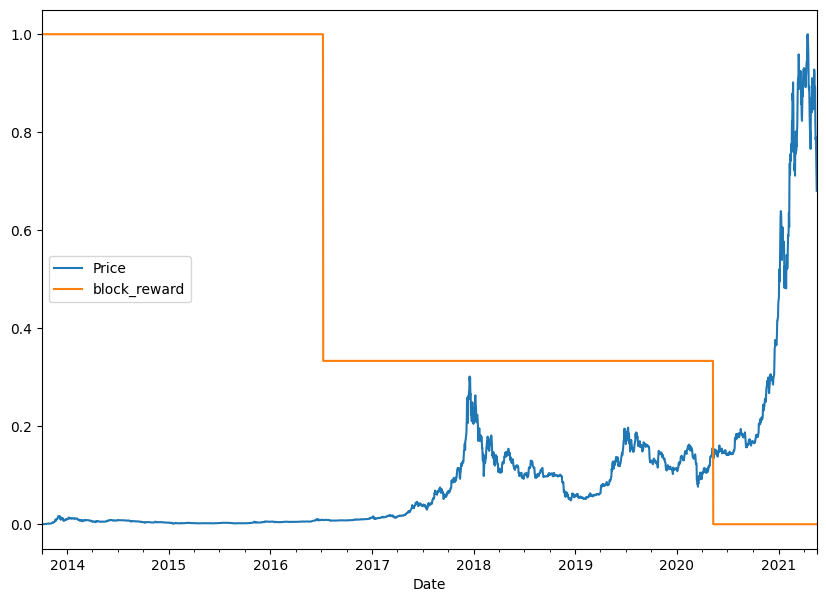

In [77]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

In [78]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [79]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [80]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [81]:
# View labels
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [82]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [83]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [84]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 284.8400


570.9136352539062

In [85]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8834.022, 8758.613, 9017.356, 8752.55 , 8713.007, 8711.009,
       8684.752, 8474.981, 8435.718, 8511.468], dtype=float32)>

In [86]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=tf.cast(y_test,dtype=tf.float64).numpy(),
                                 y_pred=tf.cast(model_6_preds,dtype=tf.float64).numpy())
model_6_results

{'mae': 570.9136,
 'mse': 1169731.4239,
 'rmse': 1081.5411,
 'mape': 0.0256,
 'mase': 1.0029}

In [87]:
model_1_results

{'mae': 567.3445,
 'mse': 1168344.2977,
 'rmse': 1080.8998,
 'mape': 0.0255,
 'mase': 30.134}

## Model 7: N-BEATS algorithm

Let's try [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf).

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*


### Building and testing an N-BEATS block layer


In [88]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Setting up the `NBeatsBlock` custom layer we see:
* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_neurons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)


In [89]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [90]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [91]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.21007769 -0.9287665  -0.6024336   0.03283449  0.02625548 -0.34166116
  0.21776623]
Forecast: 0.796053409576416


### Preparing data for the N-BEATS algorithm using `tf.data`

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).


In [92]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [93]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [94]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [95]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible

> 📖 **Resource:** For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the [*Better performance with the tf.data API*](https://www.tensorflow.org/guide/data_performance) guide.

In [96]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.


### Setting up hyperparameters for N-BEATS algorithm

To begin, we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)


*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*



In [97]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

In [98]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of **residual connections** have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



### Building, compiling and fitting the N-BEATS algorithm

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [99]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 141: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 241: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 28s, sys: 11.3 s, total: 1min 40s
Wall time: 2min 50s


And would you look at that! N-BEATS algorithm fit to our Bitcoin historical data.

How did it perform?

In [100]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 572.0310 - mae: 572.0310 - mse: 1170628.6250


[572.031005859375, 572.031005859375, 1170628.625]

In [101]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8871.601, 8799.45 , 9092.96 , 8817.76 , 8742.734, 8774.902,
       8709.389, 8510.183, 8493.487, 8544.968], dtype=float32)>

In [102]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=tf.cast(model_7_preds,dtype=tf.float64).numpy())
model_7_results

{'mae': 572.031,
 'mse': 1170628.6555,
 'rmse': 1081.9559,
 'mape': 0.026,
 'mase': nan}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.


### Plotting the N-BEATS architecture we've created

We can use [`tensorflow.keras.utils.plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) to plot our N-BEATS model.

In [103]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7, to_file="nbeats_model.png", show_shapes=True)

## Model 8: Creating an ensemble (stacking different models together)

Our next experiment is creating an [**ensemble** of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:
  * Different loss functions (sMAPE, MASE and MAPE)
  * Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can [take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting).

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results.

To create our ensemble models we're going to be using a combination of:
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models

### Constructing and fitting an ensemble of models (using different loss functions)

In [104]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

> 🔑 **Note:** With ensembles, you'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time).



In [105]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 203: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 525: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 625: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 552: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 708: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 808: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 297: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 475: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 575: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 701:

### Making predictions with an ensemble model

In [106]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [107]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8862.288 ,  8745.809 ,  9000.514 , ..., 50505.867 , 48715.2   ,
        46266.477 ],
       [ 8765.412 ,  8765.922 ,  9077.771 , ..., 49792.56  , 47758.69  ,
        45706.43  ],
       [ 8829.907 ,  8806.655 ,  9068.889 , ..., 50263.38  , 48267.574 ,
        45733.81  ],
       ...,
       [ 9108.297 ,  9014.768 ,  9130.588 , ..., 50477.87  , 49452.28  ,
        46255.49  ],
       [ 8757.9375,  8777.745 ,  9018.229 , ..., 50090.16  , 48315.434 ,
        45788.652 ],
       [ 8812.574 ,  8784.689 ,  9070.227 , ..., 50110.03  , 48168.9   ,
        45478.098 ]], dtype=float32)>

In [108]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions (Median is generally more robust than mean)
ensemble_results

{'mae': 570.1493,
 'mse': 1161206.84,
 'rmse': 1077.5931,
 'mape': 0.0258,
 'mase': nan}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**. And they're often as important as the forecast itself because **point predictions** are almost always going to be wrong. So having a range of values can help with decision making.

> 📖 **Resource(s):**
> * The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
> * For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [109]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

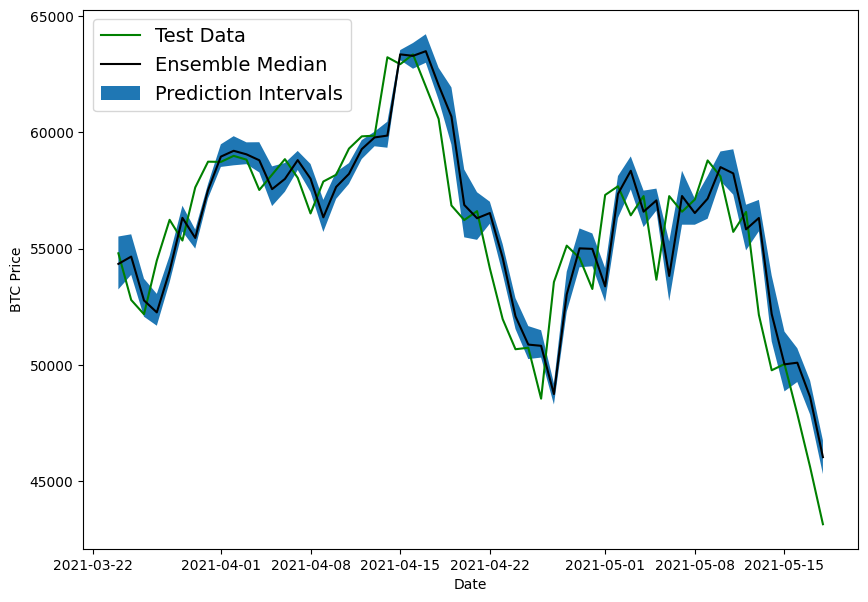

In [110]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals") # Shade the interval
plt.legend(loc="upper left", fontsize=14);

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data.

We can test this hypothesis of overfitting by creating a model to make predictions into the future.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:
* What can my model know? (with perfect data, what's possible to learn?)
* What doesn't my model know? (what can a model never predict?)

There are two types of uncertainty in machine learning you should be aware of:

* **Aleatoric uncertainty** - this type of uncertainty **cannot be reduced**, it is also referred to as "data" or "subway" uncertainty.
  * Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* **Epistemic uncertainty** - this type of uncertainty **can be reduced**, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
  * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.


## Model 9: Train a model on the full historical data to make predictions into future

> 🔑 **Note:** Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain your model to incorporate that new price to predict the next forecast.

In [111]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [112]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

Let's turn them into performance optimized TensorFlow Datasets by:
1. Turning `X_all` and `y_all` into tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
2. Combining the features and labels into a Dataset tuple using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the data using [`tf.data.Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`tf.data.Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) respectively

In [113]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [114]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the future

In [115]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input:
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
  * Eventually future predictions will be made using the model's own previous predictions as input

In [116]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

As it is, the `make_future_forecasts()` function skips the retraining of a model part.

In [117]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55574.953125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55574.953125  ] -> Prediction: 50185.5546875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55574.953125   50185.5546875 ] -> Prediction: 48500.41796875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55574.953125   50185.5546875  48500.41796875] -> Prediction: 51310.234375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55574.953125
 50185.5546875  48500.41796875 51310.234375  ] -> Prediction: 46257.98046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/ste

In [118]:
future_forecast[:10]

[np.float32(55574.953),
 np.float32(50185.555),
 np.float32(48500.418),
 np.float32(51310.234),
 np.float32(46257.98),
 np.float32(45044.617),
 np.float32(50162.0),
 np.float32(52731.664),
 np.float32(48574.453),
 np.float32(50425.953)]

### Plot future forecasts

How about we create a function to return a date range from some specified start date to a specified number of days into the future (`INTO_FUTURE`).

To do so, we'll use a combination of NumPy's [`datetime64` datatype](https://numpy.org/doc/stable/reference/arrays.datetime.html) (our Bitcoin dates are already in this datatype) as well as NumPy's `timedelta64` method which helps to create date ranges.

In [119]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [120]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [121]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [122]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55574.953, 50185.555, 48500.418, 51310.234, 46257.98 ,
        45044.617, 50162.   , 52731.664, 48574.453, 50425.953, 49779.258,
        45371.086, 48628.93 , 51953.953], dtype=float32))

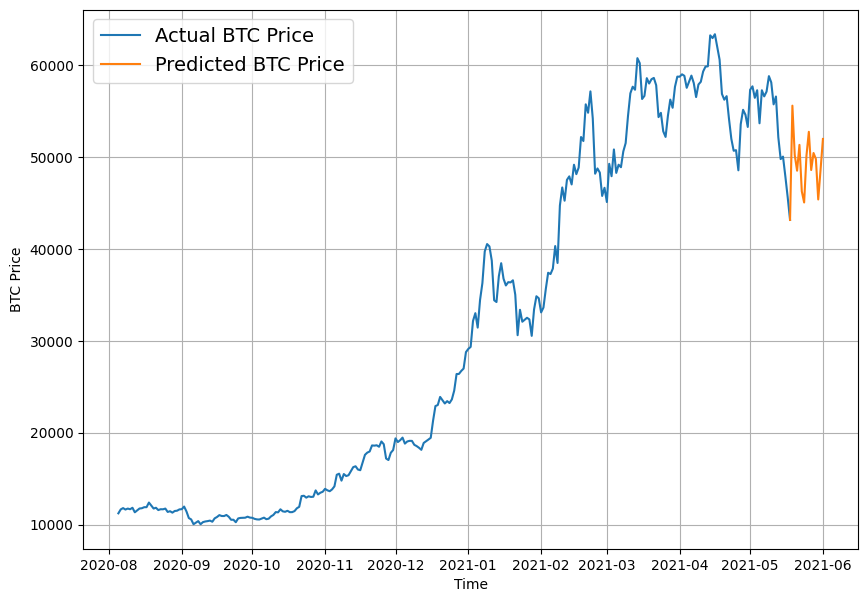

In [124]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like our predictions are starting to form a bit of a cyclic pattern (up and down in the same way). Perhaps that's due to our model overfitting the training data and not generalizing well for future data.

## Why forecasting is BS (the turkey problem 🦃)

When creating any kind of forecast, you must keep the **turkey problem** in mind.

The **turkey problem** is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

> 📖 **Resource:** If you'd like to learn more about the turkey problem, I'd recommend the following:
* [Explaining both the XIV trade and why forecasting is BS](https://youtu.be/hRwimmE2wEk) by Nassim Taleb
* [*The Black Swan*](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Taleb (epsecially Chapter 4 which outlines and discusses the turkey problem)

## Compare Models

In [137]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.9802,1.147547e+06,1071.2362,0.0252,0.9996
model_1_dense_w7_h1,567.3445,1.168344e+06,1080.8998,0.0255,30.1340
model_2_dense_w30_h1,613.8778,1.289892e+06,1135.7343,0.0276,30.1026
model_3_dense_w30_h7,1250.8824,5.347686e+06,2312.5063,0.0567,2.2259
model_4_CONV1D,571.0713,1.180556e+06,1086.5341,0.0255,30.1160
model_5_LSTM,582.9745,1.196792e+06,1093.9799,0.0262,30.0473
model_6_multivariate,570.9136,1.169731e+06,1081.5411,0.0256,1.0029
model_8_NBEATs,572.0310,1.170629e+06,1081.9559,0.0260,NaN
model_9_ensemble,570.1493,1.161207e+06,1077.5931,0.0258,NaN
model_10_turkey,642.8355,4.894133e+06,2212.2688,0.2156,26.4893


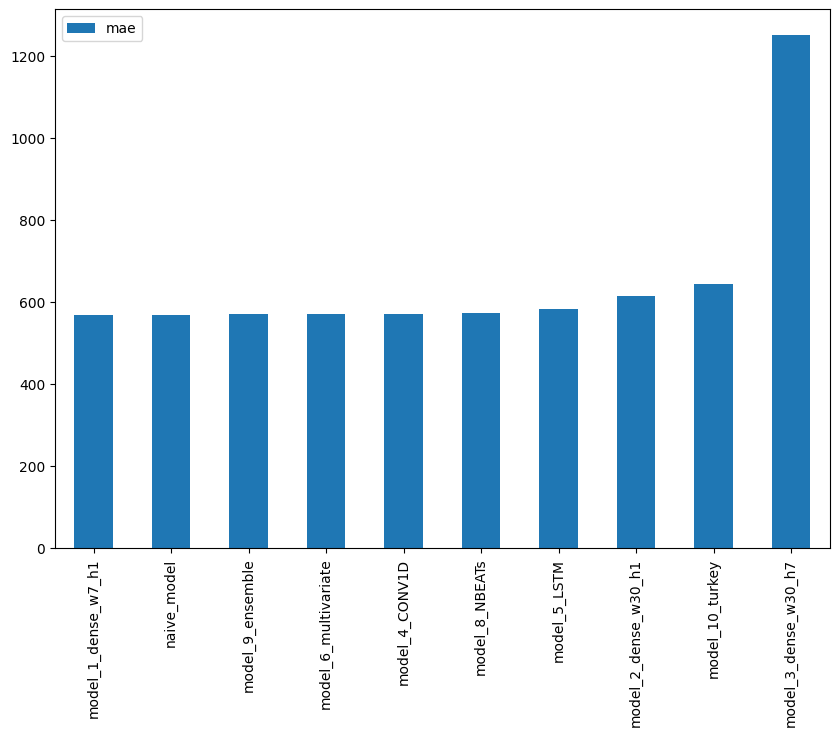

In [138]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

The majority of our deep learning models perform on par or only slightly better than the naive model.

Don't let these results get you down though, forecasting in a closed system (such as predicting the demand of electricity) often yields quite usable results.



## 📖 Extra-curriculum

If you'd like to dig deeper in to the world of time series, I'd recommend the following:

* [Forecasting: Principles and Practice](https://otexts.com/fpp3/) is an outstanding online textbook which discusses at length many of the most important concepts in time series forecasting. I'd especially recommend reading at least Chapter 1 in full.
  * I'd definitely recommend at least checking out chapter 1 as well as the chapter on forecasting accuracy measures.
* 🎥 [Introduction to machine learning and time series](https://youtu.be/wqQKFu41FIw) by Markus Loning goes through different time series problems and how to approach them. It focuses on using the `sktime` library (Scikit-Learn for time series), though the principles are applicable elsewhere.
* [*Why you should care about the Nate Silver vs. Nassim Taleb Twitter war*](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber is an outstanding discussion insight into the role of uncertainty in the example of election prediction.
* [TensorFlow time series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) - A tutorial on using TensorFlow to forecast weather time series data with TensorFlow.
* 📕 [*The Black Swan*](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Nicholas Taleb - Nassim Taleb was a pit trader (a trader who trades on their own behalf) for 25 years, this book compiles many of the lessons he learned from first-hand experience. It changed my whole perspective on our ability to predict.
* [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi, Ph.D - time series data is different to other kinds of data, if you've worked on other kinds of machine learning problems before, getting into time series might require some adjustments, Hannachi outlines 3 of the most common.
* 🎥 World-class lectures by
Jordan Kern, watching these will take you from 0 to 1 with time series problems:
  * [Time Series Analysis](https://youtu.be/Prpu_U5tKkE) - how to analyse time series data.
  * [Time Series Modelling](https://www.youtube.com/watch?v=s3XH7fTHMb4) - different techniques for modelling time series data (many of which aren't deep learning).

  * [*The Black Swan* by Nassim Nicholas Taleb](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable),


### Learning more on uncertainty

The field of quantifying uncertainty estimation in machine learning is a growing area of research.

> 📖 **Resources:** Places to learn more about uncertainty in machine learning/forecasting:
* 🎥 [MIT 6.S191: Evidential Deep Learning and Uncertainty](https://youtu.be/toTcf7tZK8c)
* [Uncertainty quantification on Wikipedia](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty)
* [*Why you should care about the Nate Silver vs. Nassim Taleb Twitter war*](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction.
* [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
* [*Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) - a discussion on techniques Uber used to engineer uncertainty estimates into their time sereis neural networks.
